Jonathan Pruchansky

I will build a model that takes two sentences as an input and returns 0 or 1 depending on whether or not they have the same semantic meaning.

##Step 1: Loading word2vec embeddings##
To avoid wasting extra time training word embeddings, we will use pretrained word embeddings. These embeddings are sourced from my results for assignment 2. I have provided the weights for this model along with the source.

In [ ]:
import numpy as np

In [ ]:
embeddings = np.load("center_vecs.npy")

##Step 2: Load, preprocess, and embed all the data##
To avoid calculating the embeddings every model run, we will pre calculate the embeddings for every datapoint. These embeddings will be fed directly as input to the models.

In [ ]:
import pandas as pd

data = pd.read_csv("questions.csv") #load data
data = data.dropna() #drop nan values

X1 = data["question1"] #input 1
X2 = data["question2"] #input 2
y = data["is_duplicate"] #labels

#Some basic statistics:
print("Basic Info:")
assert len(X1) == len(X2), "Data lengths do not match!"
print(f"Total Training Samples: {len(X1)}")
print(f"Total Positive Samples: {np.count_nonzero(y)}")
print(f"Total Negative Samples: {len(X1) - np.count_nonzero(y)}")

Basic Info:
Total Training Samples: 404348
Total Positive Samples: 149306
Total Negative Samples: 255042


In [ ]:
import json

with open("vocab_index.json") as f:
  custom_vocab = json.load(f)

print(f"Total vocab size: {len(custom_vocab)}")

Total vocab size: 102299


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(len(custom_vocab), oov_token="<unk>") #initialize tokenizer
tokenizer.word_index = custom_vocab #set custom vocab indices (to match my pretrained vocab)

X1_tokens = tokenizer.texts_to_sequences(X1) #tokenize input 1
X2_tokens = tokenizer.texts_to_sequences(X2) #tokenize input 2

#filter out empty entries (sentences that couldn't be tokenized properly)

#first, grab all the indices where the data is empty
empty_indices = {i for i in range(len(X1)) if X1_tokens[i] == [] or X2_tokens[i] == []}

#now drop those indices from every series
X1 = X1.drop(empty_indices).reset_index(drop=True)
X2 = X2.drop(empty_indices).reset_index(drop=True)
y = y.drop(empty_indices).reset_index(drop=True)

X1_tokens = [X1_tokens[i] for i in range(len(X1_tokens)) if i not in empty_indices]
X2_tokens = [X2_tokens[i] for i in range(len(X2_tokens)) if i not in empty_indices]

In [ ]:
print(X1[0])
print(X1_tokens[0])
print()
print(X2[0])
print(X2_tokens[0])

What is the step by step guide to invest in share market in india?
[46, 5, 0, 1443, 32, 1443, 3586, 4, 8362, 7, 1542, 2448, 7, 2227]

What is the step by step guide to invest in share market?
[46, 5, 0, 1443, 32, 1443, 3586, 4, 8362, 7, 1542, 2448]


In [ ]:
X1_embeddings = [[embeddings[token] for token in sentence] for sentence in X1_tokens] #convert each token to an embedding
X2_embeddings = [[embeddings[token] for token in sentence] for sentence in X2_tokens]

In [ ]:
from sklearn.model_selection import train_test_split

X_train_indx, X_test_indx, y_train, y_test = train_test_split(np.arange(len(X1)), y, test_size=0.2, random_state=1234) #split both input sets the same way

##Step 3: Approach 1 - Feedforward Neural Network##
The first approach is a simple feed foward neural network. We take the average of every embedding in the sentence and feed it into the network. It spits out a number 0 or 1.

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense

class FeedForwardClassifier(Model):
  def __init__(self, layer1_units, layer2_units):
    super().__init__()
    self.dense1 = Dense(layer1_units, activation='relu')
    self.dense2 = Dense(layer2_units, activation='relu')
    self.output_layer = Dense(1, activation='sigmoid')

  def call(self, inputs):
    """inputs: (batch_size * (2*embedding_dim))"""
    h1 = self.dense1(inputs)
    h2 = self.dense2(h1)
    return self.output_layer(h2)

#additions: could add dropout

In [ ]:
X1_avg = np.array([np.mean(sentence, axis=0) for sentence in X1_embeddings]) #find the average embedding vector for every sentence
X2_avg = np.array([np.mean(sentence, axis=0) for sentence in X2_embeddings])

In [ ]:
X_avg_concat = np.concat([X1_avg, X2_avg], axis=-1)
X_avg_concat_train = X_avg_concat[X_train_indx]

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

layer1 = 256
layer2 = 64

model = FeedForwardClassifier(layer1, layer2)
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the model
history = model.fit(X_avg_concat_train, y_train, epochs=10, batch_size=32, validation_split=.2)

Epoch 1/10
8087/8087 ━━━━━━━━━━━━━━━━━━━━ 26s 3ms/step - accuracy: 0.6935 - loss: 0.5733 - precision_4: 0.6175 - recall_3: 0.4227 - val_accuracy: 0.7329 - val_loss: 0.5139 - val_precision_4: 0.6684 - val_recall_3: 0.5498
Epoch 2/10
8087/8087 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.7414 - loss: 0.5000 - precision_4: 0.6647 - recall_3: 0.5972 - val_accuracy: 0.7428 - val_loss: 0.4960 - val_precision_4: 0.6658 - val_recall_3: 0.6101
Epoch 3/10
8087/8087 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.7546 - loss: 0.4800 - precision_4: 0.6839 - recall_3: 0.6230 - val_accuracy: 0.7501 - val_loss: 0.4859 - val_precision_4: 0.6705 - val_recall_3: 0.6360
Epoch 4/10
8087/8087 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - accuracy: 0.7656 - loss: 0.4628 - precision_4: 0.6988 - recall_3: 0.6421 - val_accuracy: 0.7533 - val_loss: 0.4795 - val_precision_4: 0.6851 - val_recall_3: 0.6151
Epoch 5/10
8087/8087 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.7723 - loss: 0.4515 - precision_4: 0.7091 - rec

In [ ]:
model.summary()

Model: "feed_forward_classifier_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,613 (580.52 KB)

 Trainable params: 49,537 (193.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 99,076 (387.02 KB)

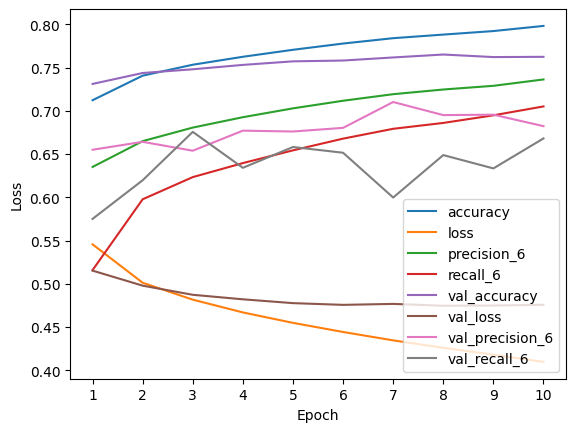

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, history.params['epochs'] + 1)
for metric, values in history.history.items():
  plt.plot(x, values, label=metric)

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(x)
plt.show()

In [ ]:
ffn_results = model.evaluate(X_avg_concat[X_test_indx], y_test)

2528/2528 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.7612 - loss: 0.4824 - precision_6: 0.6878 - recall_6: 0.6606


##Step 4: Approach 2 - Recurrent Neural Network##
The next approach is to feed the entire sentence sequentially to an RNN. This RNN will produce a single output vector which represents the context of the entire sentence. These sentences will then be compared using vector similarity techniques.

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional

class RecurrentClassifier(Model):
  def __init__(self, units):
    super().__init__()
    self.rnn = Bidirectional(LSTM(units))

  @staticmethod
  def cosine_similarity(tensor1, tensor2):
    dot_product = tf.reduce_sum(tensor1 * tensor2, axis=1)

    norm1 = tf.norm(tensor1, axis=1)
    norm2 = tf.norm(tensor2, axis=1)

    return dot_product / (norm1 * norm2)

  def call(self, inputs1, mask1, inputs2, mask2):
    """
    inputs1: (batch_size * max_len * embedding_dim)
    mask1: (batch_size * max_len)
    inputs2: (batch_size * max_len * embedding_dim)
    mask2: (batch_size * max_len)
    """
    out1 = self.rnn(inputs1, mask=mask1)
    out2 = self.rnn(inputs2, mask=mask2)

    cosine_sim = self.cosine_similarity(out1, out2)

    return tf.map_fn(lambda x: tf.cast(x > 0, tf.float32), cosine_sim)

  def train_step(self, data):
    x, y = data

    with tf.GradientTape() as tape:
      y_pred = self(*x)  # Forward pass
      # Compute the loss value
      # (the loss function is configured in `compile()`)
      loss = self.compute_loss(y=y, y_pred=y_pred)

    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    # Update metrics (includes the metric that tracks the loss)
    for metric in self.metrics:
      if metric.name == "loss":
        metric.update_state(loss)
      else:
        metric.update_state(y, y_pred)
    # Return a dict mapping metric names to current value
    return {m.name: m.result() for m in self.metrics}

  def test_step(self, data):
    x, y = data

    y_pred = self(*x)
    # Updates the metrics tracking the loss
    loss = self.compute_loss(y=y, y_pred=y_pred)
    # Update the metrics.
    for metric in self.metrics:
      if metric.name != "loss":
        metric.update_state(y, y_pred)
      else:
        metric.update_state(loss)
    # Return a dict mapping metric names to current value.
    # Note that it will include the loss (tracked in self.metrics).
    return {m.name: m.result() for m in self.metrics}

#additions: could add attention

In [ ]:
def pad_batch(batch: list[list[list[float]]], sentence_lens: list[int], pad_val: list[float]):
    """ Pad the batch for src sentences.
        Note: Do not use append/extend that can modify the input inplace.

    Args:
        src_batch: A list of src token ids
        src_seq_lens: A list of src lens
        pad_val: The padding value

    Returns:
        src_batch: Tensor, (batch_size x max_len * embedding dim)
        src_seq_lens_batch: Tensor, (batch_size, )
    """
    max_src_len = max(sentence_lens)
    # Start your code here
    # Please refer to tf.convert_to_tensor. The dtype should be tf.int64
    # Padding
    batch_out = [sample+[pad_val]*(max_src_len-length) for sample, length in zip(batch, sentence_lens)]
    # Convert to tensor

    batch_out = tf.convert_to_tensor(batch_out)
    lens_out = tf.convert_to_tensor(sentence_lens)
    # End
    return batch_out, lens_out

Using the whole dataset was taking up too much RAM so we will cut it off a little bit. (50k out of ~400k)

In [ ]:
pad_val = embeddings[tokenizer.word_index["<pad>"]]

X1_pad, X1_lens = pad_batch(X1_embeddings[:50000], [len(sentence) for sentence in X1_embeddings][:50000], pad_val)
X2_pad, X2_lens = pad_batch(X2_embeddings[:50000], [len(sentence) for sentence in X2_embeddings][:50000], pad_val)

#build masks

X1_mask = tf.sequence_mask(X1_lens, dtype=tf.float32)
X2_mask = tf.sequence_mask(X2_lens, dtype=tf.float32)

Gotta reindex the train and test set once again because of the cutoff.

In [ ]:
from sklearn.model_selection import train_test_split

X_train_indx, X_test_indx, y_train, y_test = train_test_split(np.arange(50000), y[:50000], test_size=0.2, random_state=1234) #split both input sets the same way

In [ ]:
X1_pad_train = tf.gather(X1_pad, X_train_indx)
X1_mask_train = tf.gather(X1_mask, X_train_indx)
X2_pad_train = tf.gather(X2_pad, X_train_indx)
X2_mask_train = tf.gather(X2_mask, X_train_indx)

In [ ]:
X1_pad_test = tf.gather(X1_pad, X_test_indx)
X1_mask_test = tf.gather(X1_mask, X_test_indx)
X2_pad_test = tf.gather(X2_pad, X_test_indx)
X2_mask_test = tf.gather(X2_mask, X_test_indx)

Clear the padded and mask sets from the RAM. We don't need it anymore bc we split it into test and train set, and we will use those separately.

In [ ]:
import gc
del X1_pad
del X1_mask
del X2_pad
del X2_mask

gc.collect()

0

In [ ]:
from tensorflow.keras.metrics import Precision, Recall

In [ ]:
context_dim = 16

model = RecurrentClassifier(context_dim)
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy', Precision(), Recall()])

# Train the model
inputs = (X1_pad_train, X1_mask_train, X2_pad_train, X2_mask_train)
history = model.fit(inputs, y_train, epochs=10, batch_size=32, validation_split=.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 206s 199ms/step - accuracy: 0.6192 - precision: 0.3828 - recall: 0.9970 - loss: 9.6532 - val_loss: 9.7331
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 203s 203ms/step - accuracy: 0.6203 - precision: 0.3782 - recall: 0.9979 - loss: 9.7305 - val_loss: 9.7331
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 261s 202ms/step - accuracy: 0.6193 - precision: 0.3805 - recall: 0.9978 - loss: 9.6914 - val_loss: 9.7331
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 261s 202ms/step - accuracy: 0.6159 - precision: 0.3844 - recall: 0.9976 - loss: 9.6291 - val_loss: 9.7331
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 203s 203ms/step - accuracy: 0.6226 - precision: 0.3818 - recall: 0.9979 - loss: 9.6512 - val_loss: 9.7331
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 261s 203ms/step - accuracy: 0.6193 - precision: 0.3840 - recall: 0.9968 - loss: 9.6351 - val_loss: 9.7331
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 256s 197ms/step - accuracy: 0.6247 - precision: 0.3770 - recall: 0.997

In [ ]:
model.summary()

Model: "recurrent_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (32, 32)               │        10,368 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,106 (121.51 KB)

 Trainable params: 10,368 (40.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,738 (81.01 KB)

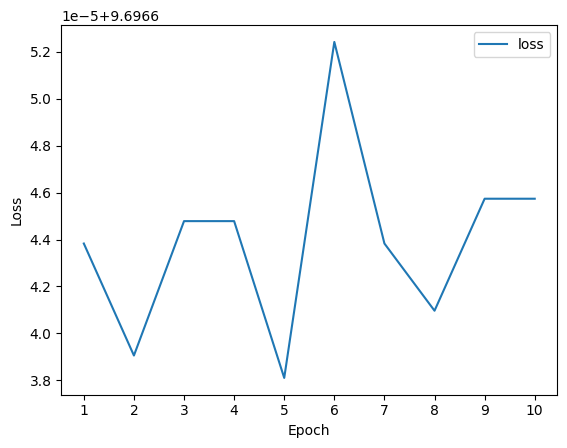

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, history.params['epochs'] + 1)
for metric, values in history.history.items():
  if metric == "loss":
    plt.plot(x, values, label=metric)

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(x)
plt.show()

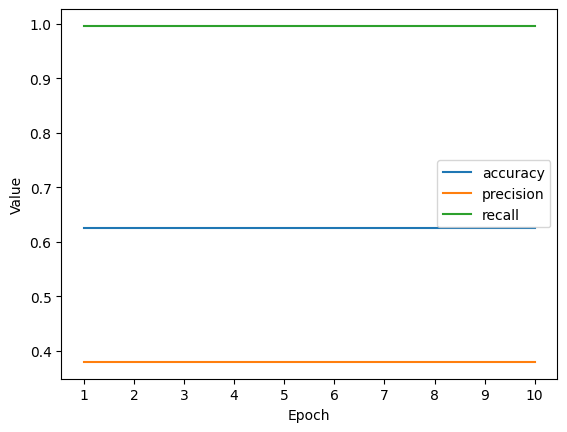

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, history.params['epochs'] + 1)
for metric, values in history.history.items():
  if "loss" not in metric:
    plt.plot(x, values, label=metric)

plt.legend()
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.xticks(x)
plt.show()

In [ ]:
test_inputs = (X1_pad_test, X1_mask_test, X2_pad_test, X2_mask_test)
rnn_results = model.evaluate(test_inputs, y_test)
rnn_results = [rnn_results[0], rnn_results[1]["accuracy"], rnn_results[1]["precision"], rnn_results[1]["recall"]]

313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.6238 - precision: 0.3813 - recall: 0.9970 - loss: 9.6936


##Step 5: Final Approach - Encoder Decoder Model##
The final approach that I came up with is to combine both of the strategies used above. We will first feed the sentences to an encoder RNN, which will output a context state. We concatenate the context of sentence 1 and 2. Then we will feed the total context state to a feed forward network which will act as a decoder, classifying the sentences as similar or not.

In [ ]:
class EncoderDecoderClassifier(Model):
  def __init__(self, units, layer1, layer2):
    super().__init__()
    self.rnn = Bidirectional(LSTM(units))
    self.ffn = FeedForwardClassifier(layer1, layer2)

  def call(self, sentence1, mask1, sentence2, mask2):
    """
    sentence1: (batch_size * max_len * embedding_dim)
    mask1: (batch_size * max_len)
    sentence2: (batch_size * max_len * embedding_dim)
    mask2: (batch_size * max_len)
    """
    context1 = self.rnn(sentence1, mask=mask1) # (batch_size * 2units)
    context2 = self.rnn(sentence2, mask=mask2) # (batch_size * 2units)

    #print("c1", context1.shape)
    #print("c2", context2.shape)

    concat_context = tf.concat([context1, context2], axis=-1) #(batch_size * 4units)
    #print("c", concat_context.shape)

    return self.ffn(concat_context)

  def train_step(self, data):
    x, y = data

    with tf.GradientTape() as tape:
      y_pred = self(*x)  # Forward pass
      # Compute the loss value
      # (the loss function is configured in `compile()`)
      loss = self.compute_loss(y=y, y_pred=y_pred)

    # Compute gradients
    trainable_vars = self.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    # Update weights
    self.optimizer.apply_gradients(zip(gradients, trainable_vars))
    # Update metrics (includes the metric that tracks the loss)
    for metric in self.metrics:
      if metric.name == "loss":
        metric.update_state(loss)
      else:
        metric.update_state(y, y_pred)
    # Return a dict mapping metric names to current value
    return {m.name: m.result() for m in self.metrics}

  def test_step(self, data):
    x, y = data

    y_pred = self(*x)
    # Updates the metrics tracking the loss
    loss = self.compute_loss(y=y, y_pred=y_pred)
    # Update the metrics.
    for metric in self.metrics:
      if metric.name != "loss":
        metric.update_state(y, y_pred)
      else:
        metric.update_state(loss)
    # Return a dict mapping metric names to current value.
    # Note that it will include the loss (tracked in self.metrics).
    return {m.name: m.result() for m in self.metrics}

In [ ]:
layer1 = 256
layer2 = 64
context_dim = 64

model = EncoderDecoderClassifier(context_dim, layer1, layer2)
model.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy', Precision(name="enc_dec_precision"), Recall(name="enc_dec_recall")])

# Train the model
inputs = (X1_pad_train, X1_mask_train, X2_pad_train, X2_mask_train)
history = model.fit(inputs, y_train, epochs=10, batch_size=32, validation_split=.2)

Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 326s 319ms/step - accuracy: 0.6586 - enc_dec_precision: 0.5646 - enc_dec_recall: 0.2770 - loss: 0.6158 - val_loss: 0.5613
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 335s 335ms/step - accuracy: 0.7198 - enc_dec_precision: 0.6460 - enc_dec_recall: 0.5440 - loss: 0.5402 - val_loss: 0.5379
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 334s 334ms/step - accuracy: 0.7424 - enc_dec_precision: 0.6668 - enc_dec_recall: 0.6057 - loss: 0.5012 - val_loss: 0.5205
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 334s 334ms/step - accuracy: 0.7643 - enc_dec_precision: 0.7010 - enc_dec_recall: 0.6539 - loss: 0.4685 - val_loss: 0.5232
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 382s 334ms/step - accuracy: 0.7869 - enc_dec_precision: 0.7164 - enc_dec_recall: 0.7087 - loss: 0.4338 - val_loss: 0.5266
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 382s 334ms/step - accuracy: 0.8108 - enc_dec_precision: 0.7469 - enc_dec_recall: 0.7480 - loss: 0.3935 - val_loss: 0.5586
Epoch 7/10
1000/

In [ ]:
model.summary()

Model: "encoder_decoder_classifier_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (32, 128)              │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feed_forward_classifier_2       │ ?                      │        82,305 │
│ (FeedForwardClassifier)         │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 445,061 (1.70 MB)

 Trainable params: 148,353 (579.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 296,708 (1.13 MB)

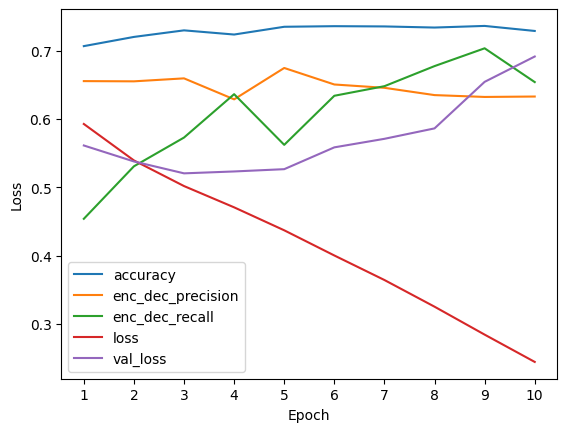

In [ ]:
import matplotlib.pyplot as plt

x = np.arange(1, history.params['epochs'] + 1)
for metric, values in history.history.items():
  plt.plot(x, values, label=metric)

plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(x)
plt.show()

In [ ]:
test_inputs = (X1_pad_test, X1_mask_test, X2_pad_test, X2_mask_test)
enc_dec_results = model.evaluate(test_inputs, y_test)
enc_dec_results = [enc_dec_results[0], enc_dec_results[1]["accuracy"], enc_dec_results[1]["enc_dec_precision"], enc_dec_results[1]["enc_dec_recall"]]

313/313 ━━━━━━━━━━━━━━━━━━━━ 35s 107ms/step - accuracy: 0.7341 - enc_dec_precision: 0.6346 - enc_dec_recall: 0.6870 - loss: 0.7190


##Step 6: Results Analysis and Conclusion##

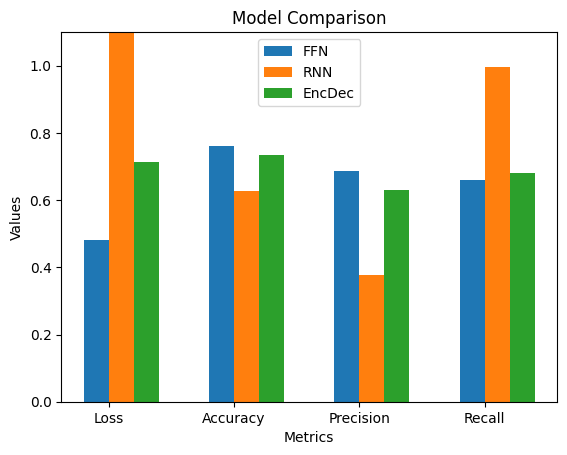

In [ ]:
categories = ["Loss", "Accuracy", "Precision", "Recall"]

bar_width = .2

x = np.arange(len(categories))
plt.bar(x, ffn_results, width=bar_width, label="FFN")
plt.bar(x+bar_width, rnn_results, width=bar_width, label="RNN")
plt.bar(x+2*bar_width, enc_dec_results, width=bar_width, label="EncDec")

plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Model Comparison")
plt.xticks(x + bar_width / 2, categories)
plt.ylim(0, 1.1)
plt.legend()

plt.show()